<a href="https://colab.research.google.com/github/Carocaro0424/Finanzas-Computacionales/blob/main/Proyecto__final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paula Andrea Caro - Santiago Rodriguez Valencia 






> Caso de aplicación: Portafolio de seguimiento  

Base teórica: 
La gestión pasiva de porta. CD folios se basa completamente en la diversificación para lograr un rendimiento deseado, por ejemplo, similar al de un índice o benchmarck. Una de las estrategias de gestión pasiva es la de “indexación” (diferente a la de “comprar y mantener”). La indexación permite construir un portafolio de seguimiento a un índice o becnhmarck. Este portafolio se denomina fondo indexado o tracking portfolio. 
Problema a tratar:
Para construir el tracking portfolio se debe seleccionar un numero K acciones dado el conjunto completo (población) de n acciones que conforman el índice, tal que K<n, pero buscando representar el comportamiento del índice lo más cercano posible.
El tracking portfolio puede construirse al resolver el siguiente problema de QP:
(x-xb)'V(x-xb) 
s.t. x'1=1
xiyi for i=1,…,n
yi K 
x0
yi∈{0,1}
Donde: x es el vector de pesos del portafolio, xb es el vector de pesos del benchmarck.
Nota: para más detalles ver Cornuejols, Peña y Tutuncu (sección 9.3).

Para completar:
i. Resolver el problema de optimización usando restricciones de cardinalidad.
ii. Implementar el modelo para construir un portafolio de seguimiento sobre un índice (DJI, STOXX50, etc..)
iii. Usar simulación de Monte Carlo para complementar el análisis de riesgos del portafolio de seguimiento.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy import stats
from scipy.stats import norm
!pip install --quiet yfinance
import yfinance as yf

In [2]:
# Descargar precios del índice DJI y calcular retornos
dji = yf.download("^DJI", period='5y')['Adj Close']
dji_returns = dji.pct_change().dropna()
dji_returns.mean()

[*********************100%***********************]  1 of 1 completed


0.0003306871505364766

In [59]:
import random

acciones = ["AAPL", "AMGN", "AXP", "BA", "CAT", "CRM", "CSCO", "CVX", "DIS", "DOW", "GS", "HD", "HON", "IBM", "INTC", "JNJ", "JPM", "KO", "MCD", "MMM", "MRK", "MSFT", "NKE", "PG", "TRV", "UNH", "V", "VZ", "WBA", "WMT"]
acciones_seleccionadas = random.sample(acciones, 20)
print(acciones_seleccionadas)

['AAPL', 'KO', 'UNH', 'AMGN', 'MSFT', 'WMT', 'DOW', 'HD', 'DIS', 'GS', 'MRK', 'IBM', 'NKE', 'INTC', 'BA', 'MCD', 'JPM', 'MMM', 'WBA', 'VZ']


In [66]:
# Descargar los precios de acciones que podrian cumplir los requerimientos de cardinalidad 
dow_jones_symbols = ['AAPL', 'CSCO', 'VZ', 'MCD', 'MRK', 'JPM', 'TRV', 'INTC', 'NKE', 'PG', 'V', 'HON', 'GS', 'IBM', 'AXP', 'BA', 'AMGN', 'MSFT', 'WBA', 'CVX']
data = yf.download(dow_jones_symbols, period='5y')['Adj Close']
returns = data.pct_change().dropna()
n = len(dow_jones_symbols)
benchmark_weights = np.ones(n) / n
mu = returns.mean()
cov = returns.cov()
sigma = returns.std()



[*********************100%***********************]  20 of 20 completed


In [67]:
def build_tracking_portfolio(returns, benchmark_weights, cardinality):
    n = len(returns.columns)
    x = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(x - benchmark_weights, np.cov(returns.T)))
    constraints = [cp.sum(x) == 1] # Restricción de suma de pesos igual a 1
    constraints += [cp.sum(cp.abs(x)) <= cardinality] # Restricción de cardinalidad
    problem = cp.Problem(objective, constraints)
    problem.solve()
    weights = x.value
    return weights


In [68]:
# Calcular el tracking portafolio dándole lugar a las 10 acciones seleccionadas del índice
cardinality = 20 # Ejemplo de cardinalidad, se puede ajustar 
tracking_portfolio = build_tracking_portfolio(returns, benchmark_weights, cardinality)
#Imprimir los pesos del portafolio de seguimiento
print("El tracking portfolio es", tracking_portfolio, sep='\n')

El tracking portfolio es
[0.05       0.05000001 0.05000001 0.05       0.05000001 0.05
 0.04999999 0.04999999 0.05000001 0.05       0.05000001 0.04999999
 0.05000001 0.05       0.05000001 0.05000002 0.05000002 0.05
 0.04999997 0.05      ]


In [69]:
# Calcular los retornos del tracking portfolio
tracking_returns = np.dot(returns, tracking_portfolio)

In [70]:
# Calcular los retornos acumulados del tracking portfolio y del índice
tracking_cumulative_returns = (1 + tracking_returns).cumprod()
dji_cumulative_returns = (1 + dji_returns).cumprod()

In [71]:
df = pd.DataFrame({'Tracking Portfolio': tracking_cumulative_returns, 'DJI': dji_cumulative_returns})

In [42]:
df

,Tracking Portfolio,DJI
Date,,
2018-05-14,1.001297,1.002748
2018-05-15,0.994544,0.994976
2018-05-16,0.999427,0.997493
2018-05-17,0.997197,0.995281
2018-05-18,0.993610,0.995325
...,...,...
2023-05-04,1.674912,1.334119
2023-05-05,1.701335,1.356133
2023-05-08,1.697589,1.353891


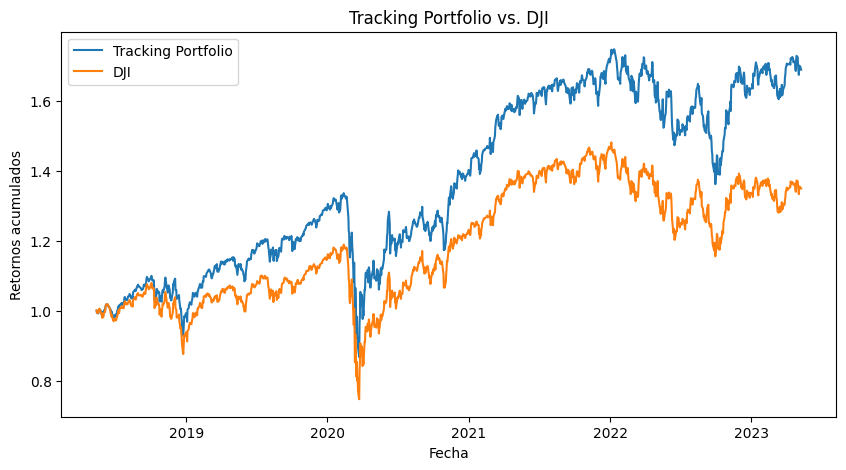

In [72]:
# Graficar los retornos acumulados del tracking portfolio y del índice
plt.figure(figsize=(10, 5))
plt.plot(df)
plt.legend(df.columns)
plt.title('Tracking Portfolio vs. DJI')
plt.xlabel('Fecha')
plt.ylabel('Retornos acumulados')
plt.show()


In [73]:
# Calcular la correlación entre los retornos del tracking portfolio y el índice DJI
correlation = np.corrcoef(tracking_returns, dji_returns)[0, 1]

In [74]:
correlation

0.984393650487626

APLICACION MONTE CARLO

In [75]:
# Usamos CVXPY para encontrar el portafolio óptimo de Sharpe o portafolio Tangente (máx. Sharpe)
x = cp.Variable(n)
objetivo = cp.Minimize(cp.quad_form(x, cov))
restricciones = [x @ mu == 1, x >= 0]
prob = cp.Problem(objetivo, restricciones)
prob.solve()
wpt = x.value/x.value.sum()

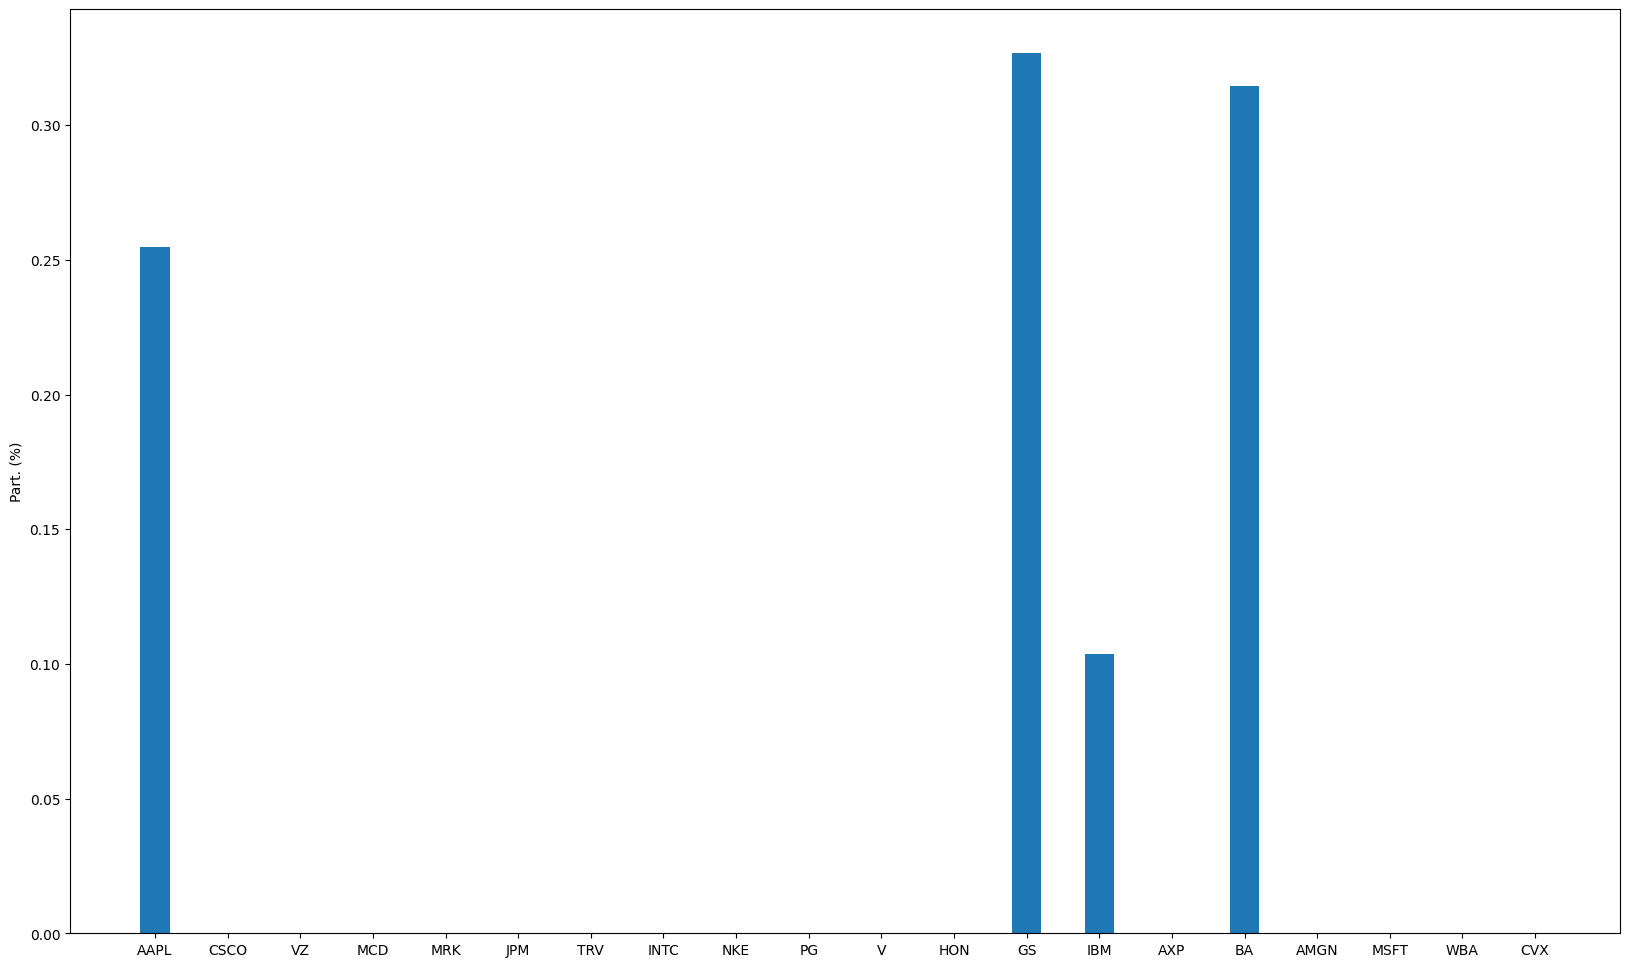

In [78]:
# Pesos del portafolio tangente de Sharpe
plt.figure(figsize = (20, 12))
plt.bar(dow_jones_symbols, wpt, width = 0.4)
plt.ylabel("Part. (%)")
plt.show();

In [79]:
# Retornos históricos del portafolio tangente y las medidas de retorno esperado y volatilidad:
ret_port = returns @ wpt
rpt = ret_port.mean()
sigmapt = ret_port.std()
print('Retorno esperado: ', rpt.round(4))
print('Volatilidad: ', sigmapt.round(4))

Retorno esperado:  0.001
Volatilidad:  0.0127


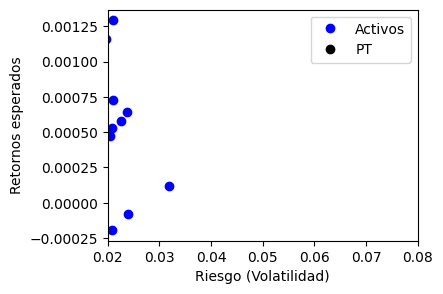

In [80]:
plt.figure(figsize=(4,3))
plt.plot(sigma, mu, 'bo')
plt.plot(sigmapt, rpt, 'ko')
plt.xlabel("Riesgo (Volatilidad)")
plt.ylabel("Retornos esperados")
plt.xlim(0.02,0.08)
plt.legend(["Activos", "PT"])
plt.show();

In [81]:
# VaR Paramétrico: usamos las medidas de retorno esperado y volatilidad del portafolio
alpha1 = 0.01                                # 1% para el 99% de confianza
VaRp1 = rpt - norm.ppf(1-alpha1)*sigmapt
print('VaR al 99%: ',VaRp1.round(4))

VaR al 99%:  -0.0286


In [82]:
alpha5 = 0.05                                # 5% para el 95% de confianza
VaRp5 = rpt - norm.ppf(1-alpha5)*sigmapt
print('VaR al 95%: ',VaRp5.round(4))

VaR al 95%:  -0.02


In [83]:
# VaR Histórico: usamos la información de retornos historicos del portafolio tangente:
VaRh1 = np.percentile(ret_port,1)                  # Percentil 1 
print('VaR histórico al 99%: ',VaRh1.round(4))

VaR histórico al 99%:  -0.0344


In [84]:
VaRh5 = np.percentile(ret_port,5)                 # # Percentil 5
print('VaR histórico al 95%: ',VaRh5.round(4))

VaR histórico al 95%:  -0.0187


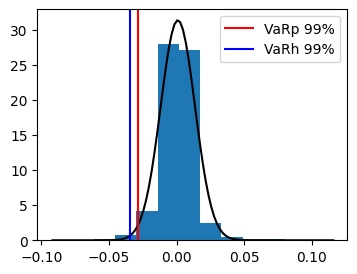

In [85]:
# Para comparar el VaR histórico y el VaR paramétrico que asume normalidad, se construye la distribucón de los 
# retornos del portafolio para encontrar las diferencias de ambos modelos:
plt.figure(figsize=(4,3))
plt.hist(ret_port, bins='sturges',density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin*0.9, xmax*1.1, 100)
p = norm.pdf(x, rpt, sigmapt)
plt.plot(x, p, 'k')                               # grafica de la distribucion normal
plt.axvline(VaRp1, color='r', label='VaRp 99%')
plt.axvline(VaRh1, color='b', label='VaRh 99%')
plt.legend(loc='upper right')
plt.show();


In [86]:
# Creamos la distrubución de los retornos del portafolio, bajo un supuesto de porbabilidad. Por ejemplo, la normal
# Se crea la muestra simulada de retornos usando la distribución Normal

n_port = 10000                                 # Se crean 10.000 retornos aleatorios para el portafolio
ma_pt = np.random.normal(rpt,sigmapt, n_port)  # tomando su retorno esperado y su volatilidad

In [87]:
ma_pt

array([ 0.00724665,  0.00555497, -0.02030256, ..., -0.00625203,
        0.01507134,  0.00177   ])

In [88]:
# Para calculo del VaR s epueden aplicar los dos procedimientos anteriores
# De la distrubición anterior obtenemos el VaR al 95%
VaR5_sim = ma_pt.mean() - norm.ppf(1-alpha5)*ma_pt.std()     # Usamos la media y la desviación de la muestra simulada
print('Comparación de resultados.', 'VaR Simulado: ', VaR5_sim.round(4), '/', 'VaR Paramétrico: ',  VaRp5.round(4))

Comparación de resultados. VaR Simulado:  -0.0199 / VaR Paramétrico:  -0.02


In [89]:
# Otras forma usando la función "percentile". De la distrubición se extrae el percentil 5
print('VaR de simulción al 95%: ', np.percentile(ma_pt,5).round(4)) 

VaR de simulción al 95%:  -0.0197


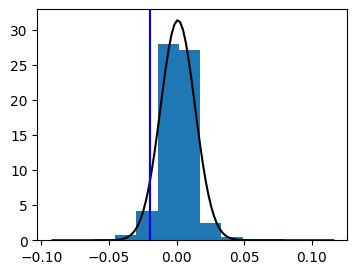

In [90]:
plt.figure(figsize=(4,3))
plt.hist(ret_port,bins='sturges',density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin*0.9, xmax*1.1, 100)
p = norm.pdf(x, rpt, sigmapt)
plt.plot(x, p, 'k')    
plt.axvline(VaRp5, color='r', label='VaRp 95%')
plt.axvline(VaR5_sim, color='b', label='VaRp 95%')
plt.show();